In [10]:
import sys

sys.path.append("..")  # Add parent directory to path

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from ldm.models.autoencoder import AutoencoderKL
from ldm.data.mnist import MNISTWrapper

In [12]:
from omegaconf import OmegaConf

MODEL_PATH = "../logs/2024-12-06T08-37-33_autoencoder_kl_8x8x64_mnist_gpu/checkpoints/epoch=000018.ckpt"

config = OmegaConf.load("../configs/autoencoder/autoencoder_kl_8x8x64_mnist_gpu.yaml")
model_config = config.model.params

model = AutoencoderKL.load_from_checkpoint(
    MODEL_PATH,
    ddconfig=model_config.ddconfig,
    lossconfig=model_config.lossconfig,
    embed_dim=model_config.embed_dim,
)
model.eval()

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 64, 7, 7) = 3136 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

## Basic reconstruction


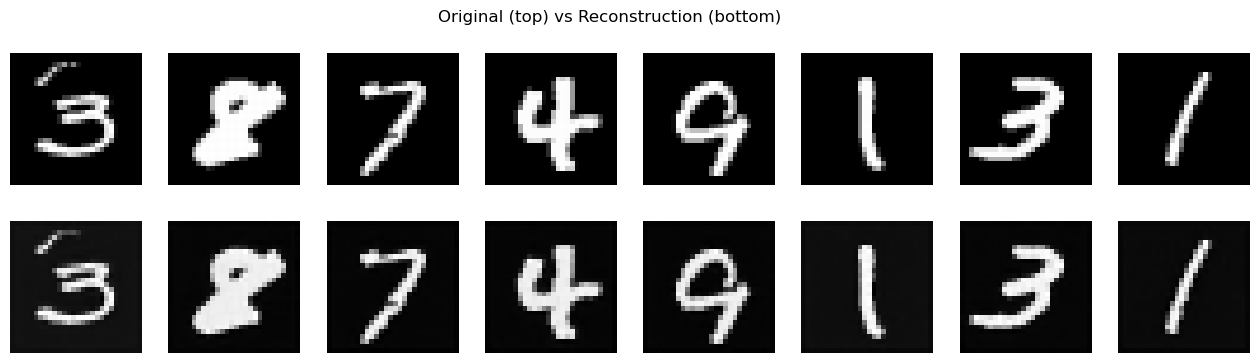

In [13]:
# Setup transforms like we did in training
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[-1.0], std=[2.0]),  # Scale to [-1,1]
    ]
)

test_dataset = torchvision.datasets.MNIST(
    root="../data/mnist", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
images, _ = next(iter(test_loader))

# Get reconstructions
model.eval()
with torch.no_grad():
    reconstructions, posteriors = model(images)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
plt.suptitle("Original (top) vs Reconstruction (bottom)")

for i in range(8):
    # Original
    axes[0, i].imshow(images[i, 0], cmap="gray")
    axes[0, i].axis("off")
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap="gray")
    axes[1, i].axis("off")
plt.show()

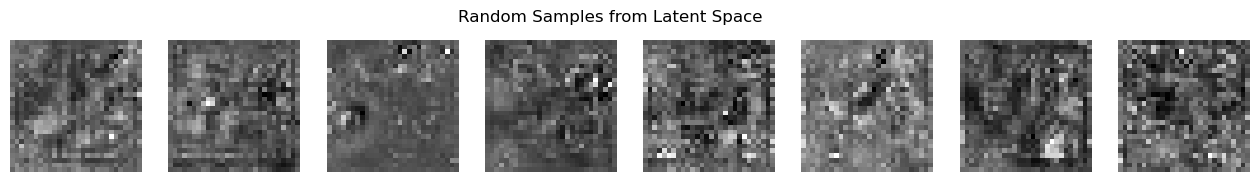

In [14]:
# 2. Latent space sampling
# Generate random samples from the latent space
n_samples = 8
with torch.no_grad():
    # Sample from unit gaussian
    z = torch.randn(n_samples, model.embed_dim, 7, 7)  # Latent shape matches our model
    samples = model.decode(z)

plt.figure(figsize=(16, 2))
plt.suptitle("Random Samples from Latent Space")
for i in range(n_samples):
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(samples[i, 0], cmap="gray")
    plt.axis("off")
plt.show()

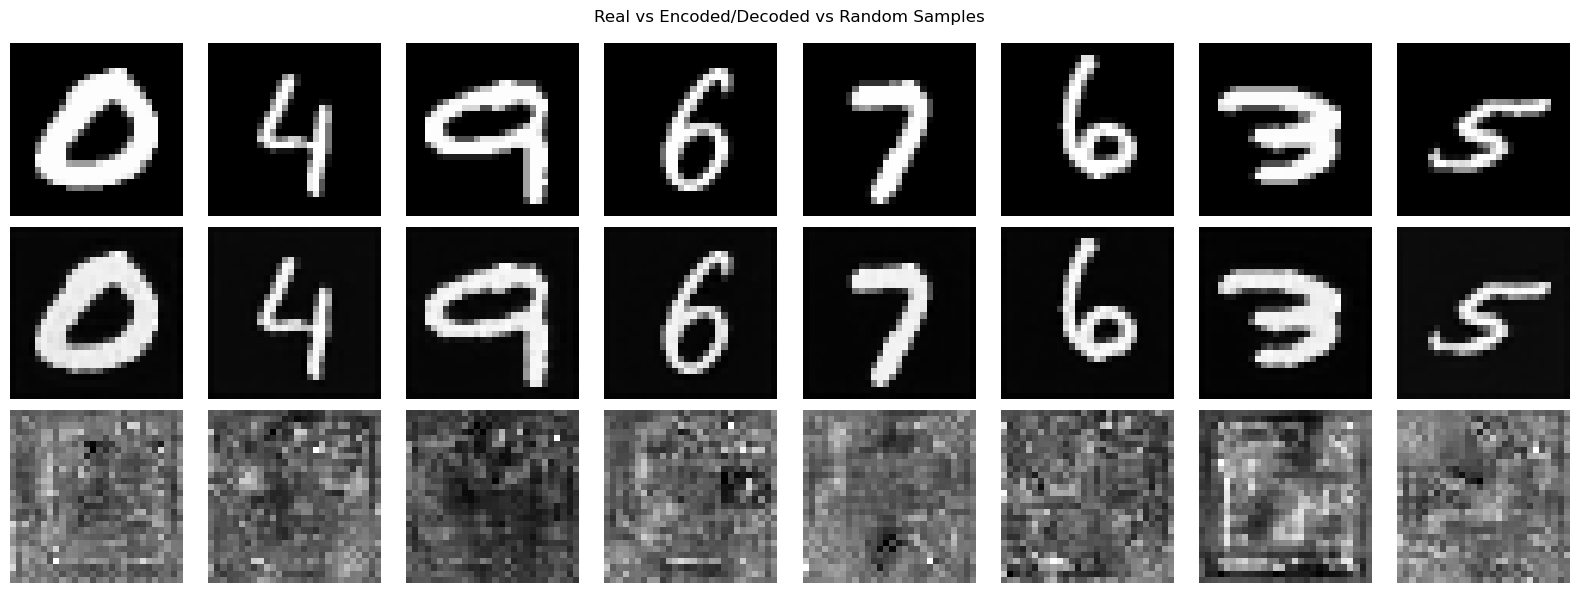

In [15]:
# Get some real MNIST digits
real_images, _ = next(iter(test_loader))

# Get their latent representations (using q(z|x))
with torch.no_grad():
    posterior = model.encode(real_images)
    z_real = posterior.sample()  # or mode() for deterministic
    reconstructions = model.decode(z_real)

    # Get random samples from p(z)
    z_random = torch.randn_like(z_real)  # Same shape but random normal
    samples = model.decode(z_random)

# Plot all three
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
plt.suptitle("Real vs Encoded/Decoded vs Random Samples")

for i in range(8):
    # Real MNIST digits
    axes[0, i].imshow(real_images[i, 0].detach().cpu(), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Real")

    # Reconstructions from encoded latents
    axes[1, i].imshow(reconstructions[i, 0].detach().cpu(), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Reconstructed")

    # Random samples
    axes[2, i].imshow(samples[i, 0].detach().cpu(), cmap="gray")
    axes[2, i].axis("off")
    if i == 0:
        axes[2, i].set_ylabel("Random p(z)")

plt.tight_layout()
plt.show()

Looks like this first model is good with reconstruction, but has a bad latent space. Lets train another one with a larger KL term.


In [16]:
from omegaconf import OmegaConf

MODEL_PATH = "../logs/2024-12-07T09-19-55_autoencoder_kl_8x8x64_mnist_gpu/checkpoints/epoch=000018.ckpt"

config = OmegaConf.load("../configs/autoencoder/autoencoder_kl_8x8x64_mnist_gpu.yaml")
model_config = config.model.params

model = AutoencoderKL.load_from_checkpoint(
    MODEL_PATH,
    ddconfig=model_config.ddconfig,
    lossconfig=model_config.lossconfig,
    embed_dim=model_config.embed_dim,
)
model.eval()

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 64, 7, 7) = 3136 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

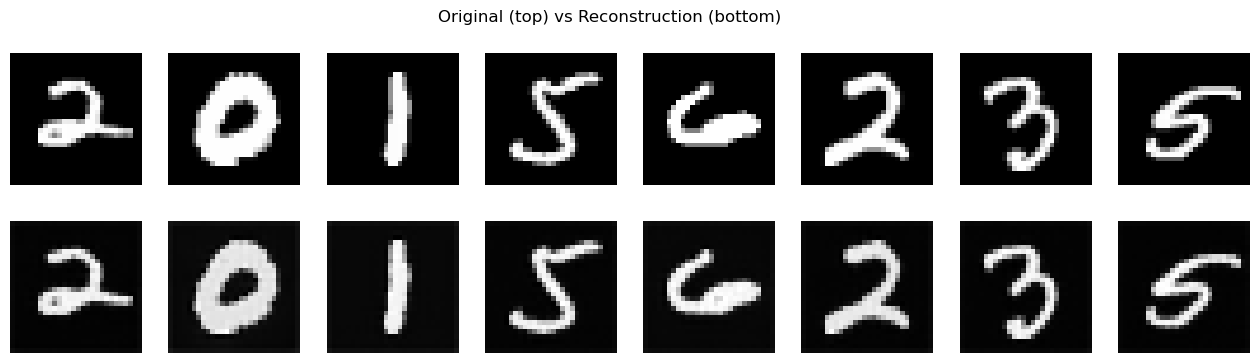

In [17]:
# Setup transforms like we did in training
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[-1.0], std=[2.0]),  # Scale to [-1,1]
    ]
)

test_dataset = torchvision.datasets.MNIST(
    root="../data/mnist", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
images, _ = next(iter(test_loader))

# Get reconstructions
model.eval()
with torch.no_grad():
    reconstructions, posteriors = model(images)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
plt.suptitle("Original (top) vs Reconstruction (bottom)")

for i in range(8):
    # Original
    axes[0, i].imshow(images[i, 0], cmap="gray")
    axes[0, i].axis("off")
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap="gray")
    axes[1, i].axis("off")
plt.show()

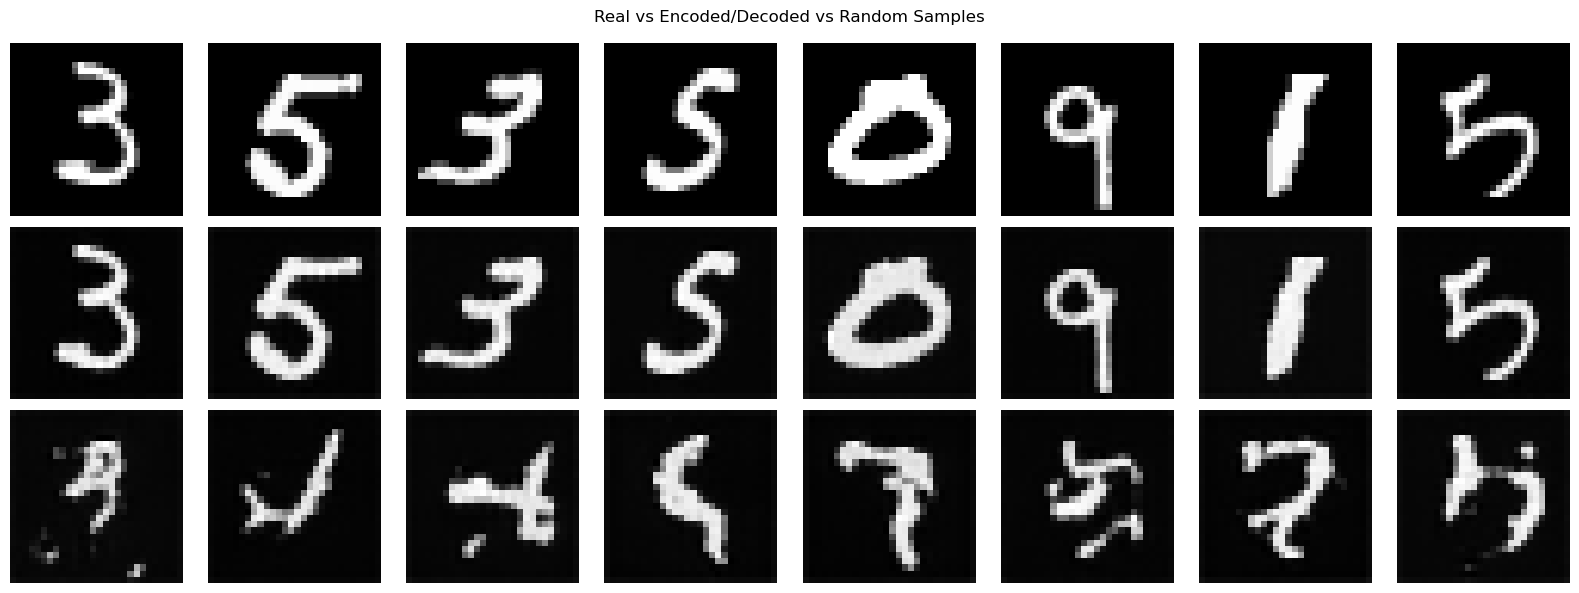

In [18]:
# Get some real MNIST digits
real_images, _ = next(iter(test_loader))

# Get their latent representations (using q(z|x))
with torch.no_grad():
    posterior = model.encode(real_images)
    z_real = posterior.sample()  # or mode() for deterministic
    reconstructions = model.decode(z_real)

    # Get random samples from p(z)
    z_random = torch.randn_like(z_real)  # Same shape but random normal
    samples = model.decode(z_random)

# Plot all three
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
plt.suptitle("Real vs Encoded/Decoded vs Random Samples")

for i in range(8):
    # Real MNIST digits
    axes[0, i].imshow(real_images[i, 0].detach().cpu(), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Real")

    # Reconstructions from encoded latents
    axes[1, i].imshow(reconstructions[i, 0].detach().cpu(), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Reconstructed")

    # Random samples
    axes[2, i].imshow(samples[i, 0].detach().cpu(), cmap="gray")
    axes[2, i].axis("off")
    if i == 0:
        axes[2, i].set_ylabel("Random p(z)")

plt.tight_layout()
plt.show()

Now lets try an even larger KL weight, 1.


In [22]:
from omegaconf import OmegaConf

MODEL_PATH = "../logs/2024-12-07T09-56-26_autoencoder_kl_8x8x64_mnist_gpu/checkpoints/epoch=000017.ckpt"

config = OmegaConf.load("../configs/autoencoder/autoencoder_kl_8x8x64_mnist_gpu.yaml")
model_config = config.model.params

model = AutoencoderKL.load_from_checkpoint(
    MODEL_PATH,
    ddconfig=model_config.ddconfig,
    lossconfig=model_config.lossconfig,
    embed_dim=model_config.embed_dim,
)
model.eval()

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 64, 7, 7) = 3136 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

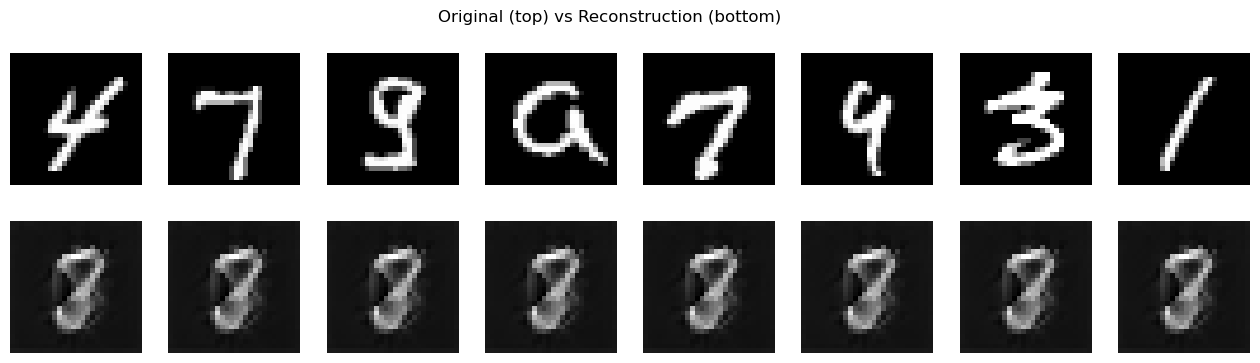

In [23]:
# Setup transforms like we did in training
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[-1.0], std=[2.0]),  # Scale to [-1,1]
    ]
)

test_dataset = torchvision.datasets.MNIST(
    root="../data/mnist", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
images, _ = next(iter(test_loader))

# Get reconstructions
model.eval()
with torch.no_grad():
    reconstructions, posteriors = model(images)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
plt.suptitle("Original (top) vs Reconstruction (bottom)")

for i in range(8):
    # Original
    axes[0, i].imshow(images[i, 0], cmap="gray")
    axes[0, i].axis("off")
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap="gray")
    axes[1, i].axis("off")
plt.show()

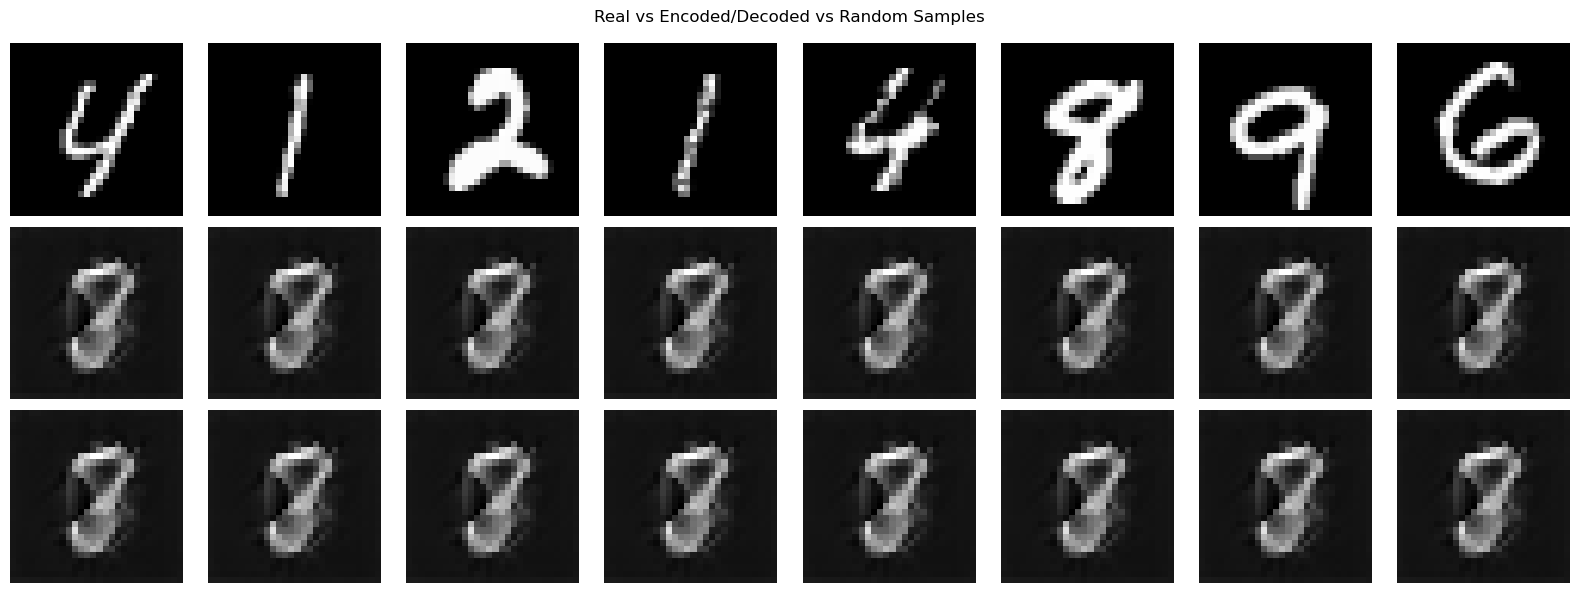

In [24]:
# Get some real MNIST digits
real_images, _ = next(iter(test_loader))

# Get their latent representations (using q(z|x))
with torch.no_grad():
    posterior = model.encode(real_images)
    z_real = posterior.sample()  # or mode() for deterministic
    reconstructions = model.decode(z_real)

    # Get random samples from p(z)
    z_random = torch.randn_like(z_real)  # Same shape but random normal
    samples = model.decode(z_random)

# Plot all three
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
plt.suptitle("Real vs Encoded/Decoded vs Random Samples")

for i in range(8):
    # Real MNIST digits
    axes[0, i].imshow(real_images[i, 0].detach().cpu(), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Real")

    # Reconstructions from encoded latents
    axes[1, i].imshow(reconstructions[i, 0].detach().cpu(), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Reconstructed")

    # Random samples
    axes[2, i].imshow(samples[i, 0].detach().cpu(), cmap="gray")
    axes[2, i].axis("off")
    if i == 0:
        axes[2, i].set_ylabel("Random p(z)")

plt.tight_layout()
plt.show()

In [31]:
from omegaconf import OmegaConf

MODEL_PATH = "../logs/2024-12-07T10-15-57_autoencoder_kl_8x8x64_mnist_gpu/checkpoints/epoch=000019.ckpt"

config = OmegaConf.load("../configs/autoencoder/autoencoder_kl_8x8x64_mnist_gpu.yaml")
model_config = config.model.params

model = AutoencoderKL.load_from_checkpoint(
    MODEL_PATH,
    ddconfig=model_config.ddconfig,
    lossconfig=model_config.lossconfig,
    embed_dim=model_config.embed_dim,
)
model.eval()

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 64, 7, 7) = 3136 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

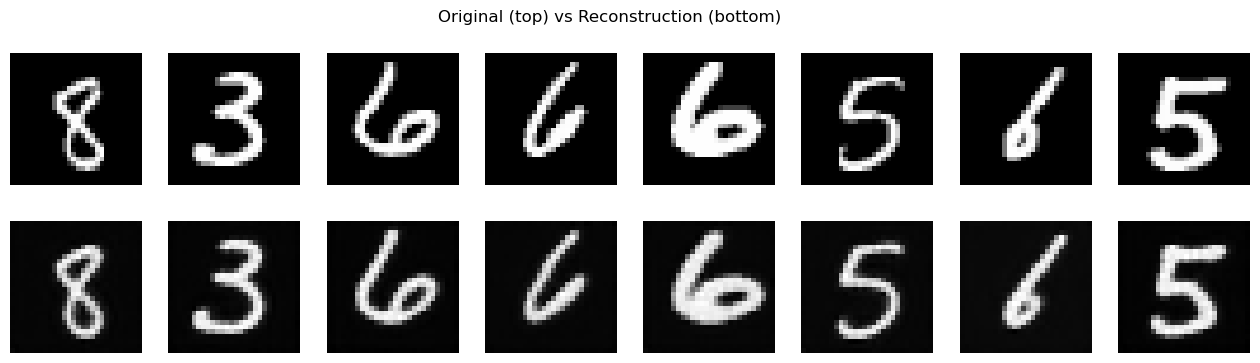

In [32]:
# Setup transforms like we did in training
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[-1.0], std=[2.0]),  # Scale to [-1,1]
    ]
)

test_dataset = torchvision.datasets.MNIST(
    root="../data/mnist", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
images, _ = next(iter(test_loader))

# Get reconstructions
model.eval()
with torch.no_grad():
    reconstructions, posteriors = model(images)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
plt.suptitle("Original (top) vs Reconstruction (bottom)")

for i in range(8):
    # Original
    axes[0, i].imshow(images[i, 0], cmap="gray")
    axes[0, i].axis("off")
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap="gray")
    axes[1, i].axis("off")
plt.show()

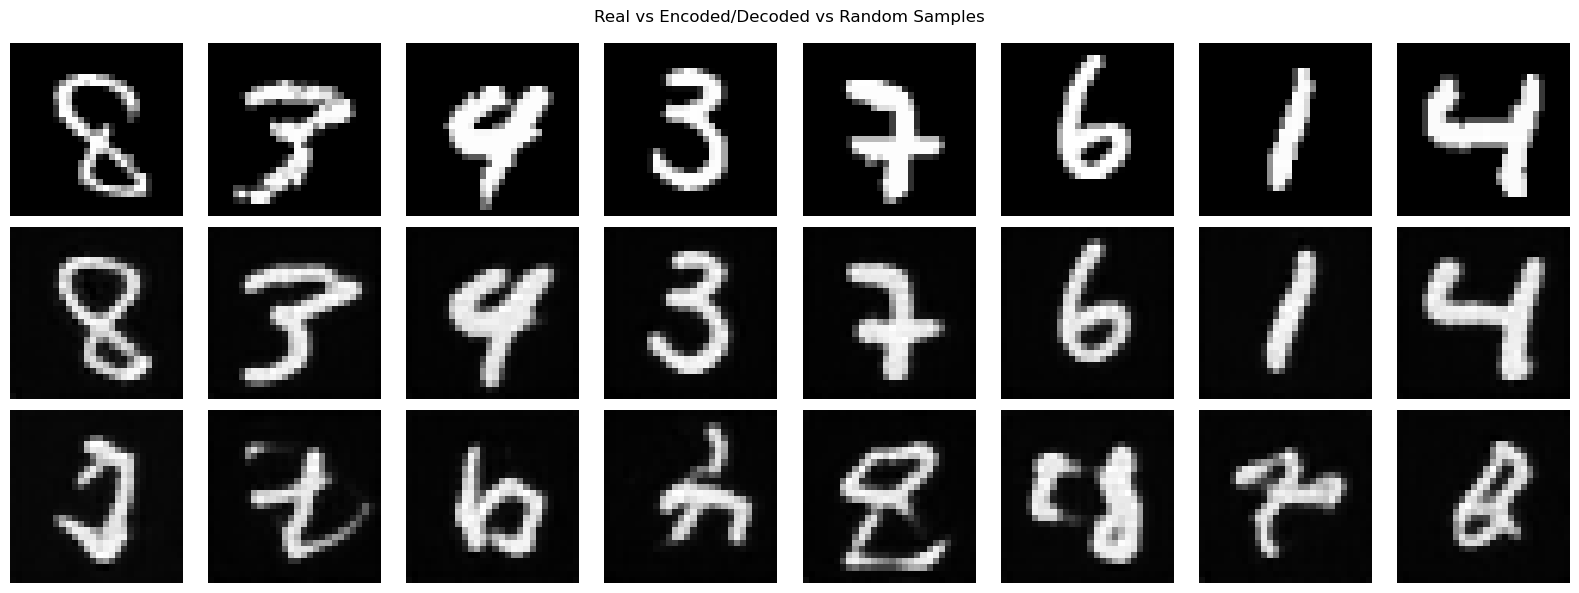

In [33]:
# Get some real MNIST digits
real_images, _ = next(iter(test_loader))

# Get their latent representations (using q(z|x))
with torch.no_grad():
    posterior = model.encode(real_images)
    z_real = posterior.sample()  # or mode() for deterministic
    reconstructions = model.decode(z_real)

    # Get random samples from p(z)
    z_random = torch.randn_like(z_real)  # Same shape but random normal
    samples = model.decode(z_random)

# Plot all three
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
plt.suptitle("Real vs Encoded/Decoded vs Random Samples")

for i in range(8):
    # Real MNIST digits
    axes[0, i].imshow(real_images[i, 0].detach().cpu(), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Real")

    # Reconstructions from encoded latents
    axes[1, i].imshow(reconstructions[i, 0].detach().cpu(), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Reconstructed")

    # Random samples
    axes[2, i].imshow(samples[i, 0].detach().cpu(), cmap="gray")
    axes[2, i].axis("off")
    if i == 0:
        axes[2, i].set_ylabel("Random p(z)")

plt.tight_layout()
plt.show()